In [ ]:
from importlib import reload
import sys
import os
sys.path.append(os.path.abspath('../'))
import util
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

In [3]:
prices = util.load_all_price_data(1).iloc[:60000]
squid_vwap = util.get_vwap(prices, 'SQUID_INK')
log_ret = np.log(squid_vwap).diff().dropna()

0.6274445316940891


<Axes: ylabel='Count'>

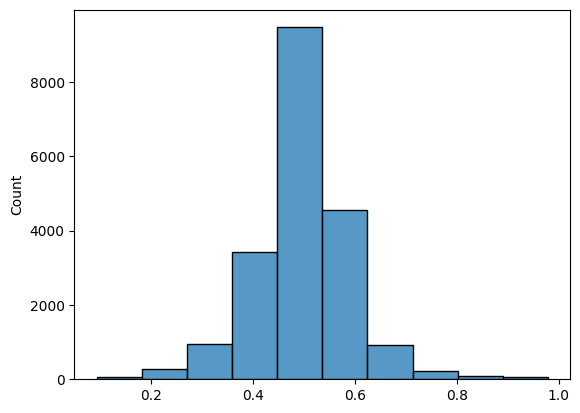

In [41]:
def macd(squid_vwap, short_lookback=10, long_lookback=20):
    """
    Compute the cumulative moving average of the squid vwap.
    """
    raw_macd = squid_vwap.ewm(span=short_lookback, adjust=False).mean() - squid_vwap.ewm(span=long_lookback, adjust=False).mean()
    distance = (long_lookback-1)/2
    distance -= (short_lookback-1)/2
    norm = 3*np.sqrt(distance)
    def sigmoid(x):
        return 1/(1 + np.exp(-x))
    norm_macd = sigmoid(1.5*raw_macd/norm)
    return norm_macd


def relative_entropy_binned(data: pd.Series, num_bins: int) -> float:
    # Compute histogram: counts and bin edges
    counts, bin_edges = np.histogram(data, bins=num_bins)
    # Normalize counts to create a probability distribution (p)
    total = counts.sum()
    if total == 0:
        raise ValueError("The data series is empty or contains no values within the bins.")
    p = counts / total
    entropy = -np.sum(p * np.log(p + 1e-10))  # Adding a small value to avoid log(0)
    
    return entropy/np.log(num_bins)
squid_macd = macd(squid_vwap, short_lookback=15, long_lookback=50)
p = print
p(relative_entropy_binned(squid_macd, 10))
sns.histplot(squid_macd, bins=10)

In [44]:
def get_portfolio(signal_series, long_threshold, short_threshold):
    """
    Get portfolio based on signal series.
    """
    portfolio = pd.Series(index=signal_series.index, dtype=float)
    portfolio[signal_series > long_threshold] = 1  # Long position
    portfolio[signal_series < short_threshold] = -1  # Short position
    portfolio.fillna(0, inplace=True)  # No position
    return portfolio
def get_returns(returns, portfolio, tc = 1.5/2000, lookforward = 1):
    """
    Get returns based on portfolio.
    """
    returns = returns.rolling(lookforward).sum()
    to = abs(portfolio.diff())
    portfolio_returns = portfolio.shift(lookforward) * returns- to * tc
    return portfolio_returns.dropna()

In [45]:
def get_performance_table(signal, returns):
    thresholds = np.linspace(0.01, 0.99, 49)
    sigmax, sigmin = signal.max(), signal.min()
    performance_data = []
    
    for threshold_frac in thresholds:
        threshold = np.quantile(signal, threshold_frac)
        buy_portfolio = get_portfolio(signal, threshold, sigmin)
        buy_returns = get_returns(returns, buy_portfolio)
        buy_cum_returns = (buy_returns).sum()
        sell_portfolio = -get_portfolio(signal, threshold, sigmin)
        sell_returns = get_returns(returns, sell_portfolio)
        sell_cum_returns = (sell_returns).sum()

        sellless_portfolio = get_portfolio(signal, sigmax, threshold)
        sellless_returns = get_returns(returns, sellless_portfolio)
        sellless_cum_returns = (sellless_returns).sum()
        buyless_portfolio = -get_portfolio(signal, sigmax, threshold)
        buyless_returns = get_returns(returns, buyless_portfolio)   
        buyless_cum_returns = (buyless_returns).sum()

        performance_data.append({
            'Threshold': threshold,
            'FracGreater': 1-threshold_frac,
            'LongTotRet': buy_cum_returns,
            'ShortTotRet': sell_cum_returns,
            'FracLess': threshold_frac,
            'Long2TotRet': buyless_cum_returns,
            'Short2TotRet': sellless_cum_returns
        })
    performance_df = pd.DataFrame(performance_data)
    return performance_df
macd_performance = round(get_performance_table(squid_macd, log_ret),2)
macd_performance

,Threshold,FracGreater,LongTotRet,ShortTotRet,FracLess,Long2TotRet,Short2TotRet
0,0.24,0.99,-0.05,0.01,0.01,-0.01,-0.03
1,0.31,0.97,-0.07,-0.03,0.03,-0.04,-0.05
2,0.34,0.95,-0.12,-0.05,0.05,-0.06,-0.11
3,0.37,0.93,-0.15,-0.06,0.07,-0.07,-0.13
4,0.38,0.91,-0.18,-0.06,0.09,-0.07,-0.17
5,0.40,0.89,-0.17,-0.08,0.11,-0.10,-0.16
6,0.41,0.87,-0.19,-0.10,0.13,-0.12,-0.18
7,0.42,0.85,-0.21,-0.14,0.15,-0.15,-0.20
8,0.43,0.83,-0.24,-0.17,0.17,-0.18,-0.23
9,0.44,0.81,-0.26,-0.19,0.19,-0.20,-0.24
